# Purpose:

Determine whether the size distortion methods in my simulator are function as expected and if my pseudobulk data with 100% coverage will give me expected results. 

In [72]:
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sciAnalysis import *
import numpy as np

In [6]:
def extrStates(states):
    #I am attempting to conform the reading of these known labels to the way that I have produced the HMM labels
    #within sciAnalysis so I can re-use code....
    state_tuples = []
    if len(states) > 1:
        for s in range(len(states)-1):
            state_tuples.append((states[s], states[s+1]))
    else:
        state_tuples.append(states[0])
    
    return state_tuples

def readCO(tsv, path):
    #Record only the individuals that are unique the sampling to get the true AF
    COs = []
    labels = []
    add_Mb = {'2L': 0, '2R': 23000000, '3L': 0, '3R': 24500000, 'X': 0}
    full_tsv = os.path.join(path, tsv)
    with open(full_tsv, 'r') as myTsv:
        TSV_reader = csv.reader(myTsv, delimiter='\t')

        index = 0
        for field in TSV_reader:
            #each individual will have an array of their breakpoints and their chromosome states
            chr2 = [int(pos)/1000000 for pos in field[2].split(',') if pos != ''] + [(int(pos) + add_Mb['2R'])/1000000 for pos in field[5].split(',') if pos != '']
            chr2_states = [int(segment) for segment in field[3].split(',')][:-1] + [int(segment) for segment in field[6].split(',')]
            refChr2 = extrStates(states=chr2_states)
            
            chr3 = [int(pos)/1000000 for pos in field[8].split(',') if pos != ''] + [(int(pos) + add_Mb['3R'] )/1000000for pos in field[11].split(',') if pos != '']
            chr3_states = [int(segment) for segment in field[9].split(',')][:-1] + [int(segment) for segment in field[12].split(',')]
            refChr3 = extrStates(states= chr3_states)
            
            chrx = [int(pos)/1000000 for pos in field[14].split(',') if pos != '']
            chrx_states = [int(segment) for segment in field[15].split(',')]
            refChrx = extrStates(states=chrx_states)
            
            all_labels = [refChr2, refChr3, refChrx]
            all_COS = [chr2, chr3, chrx]
            COs.append(all_COS)
            labels.append(all_labels)
            
            index += 1
            
    return COs, labels



In [147]:
def sciAnalysis_methods(CO_data, state_labels):
    myAnalysis = analyzeSEQ()
    myAnalysis.polarized_samples = myAnalysis.load_SNP_array(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/',
                                                            snp_array='SIZE_TEST_NEW.npy', encoding='latin1')
    myAnalysis.paintedGenome = [np.concatenate((myAnalysis.polarized_samples[0][0][:, 0], myAnalysis.polarized_samples[0][1][:, 0] + 23000000)) / 1000000,
                                np.concatenate((myAnalysis.polarized_samples[0][2][:, 0], myAnalysis.polarized_samples[0][3][:, 0] + 24500000)) / 1000000,
                                myAnalysis.polarized_samples[0][4][:, 0] / 1000000]

    SNP_pileup = []
    for sample in range(len(state_labels)):
        
        SNPs = myAnalysis.paintChromosome(breakpoints=CO_data[sample], labels=state_labels[sample])
        SNP_pileup.append(SNPs)
    
    for arm in range(3):
        myAnalysis.paintedGenome[arm] = np.vstack((myAnalysis.paintedGenome[arm], np.sum(np.vstack(np.vstack(SNP_pileup)[:,arm]), axis=0) / (2*len(state_labels)))).T
    
    #Compute SD params
    params, errs, AFs = myAnalysis.estimateSD_params(myAnalysis.paintedGenome)
    
    
    #Do the plotting
    with sns.axes_style('whitegrid'):
        fig = plt.figure(figsize=(12,5))
        sns.scatterplot(myAnalysis.paintedGenome[1][:,0], myAnalysis.paintedGenome[1][:,1],edgecolor=None, alpha=.1, color='black')
        plt.plot(AFs[1][:,0], AFs[1][:,1], linestyle='--', color='blue')
        plt.title('Chr3 theoretical pseudobulk')
        plt.xlabel('Mb')
        plt.ylabel('P2 AF')
        plt.show()
        plt.close()

    print('Driver strength: {0:.2f}'.format(params[1][0]*100))
    

In [60]:
def WRAP_all(tsv, path):
    CO_data, state_labels = readCO(path=path, tsv= tsv)
    
    sciAnalysis_methods(CO_data, state_labels)

SNP input loaded... 2149 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


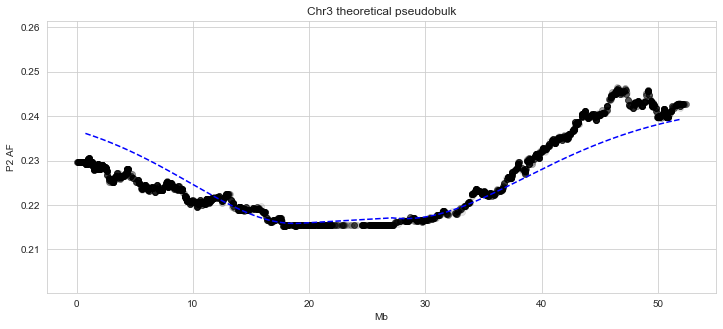

Driver strength: 6.93


In [56]:
WRAP_all(tsv='7-19_test2_crossovers.tsv', path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/')

My testing of the theoretical pseudobulk distortion seems to be giving me the incorrect value for predicted drive strength. I gave parameter of 20% size distortion to the simulator but the distortion that is seen here is only 7%. 

SNP input loaded... 2088 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


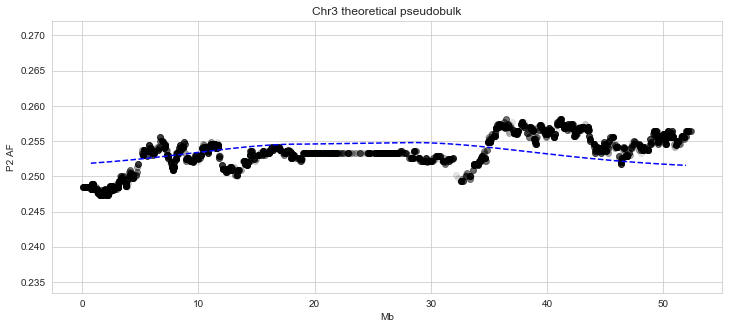

Driver strength: -0.97


In [67]:
WRAP_all(tsv='TEST_noD_crossovers.tsv', path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/')

No size or segregation distortion seems to look correct with some noise that would be levelled out by my clustering hopefully.

SNP input loaded... 3282 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


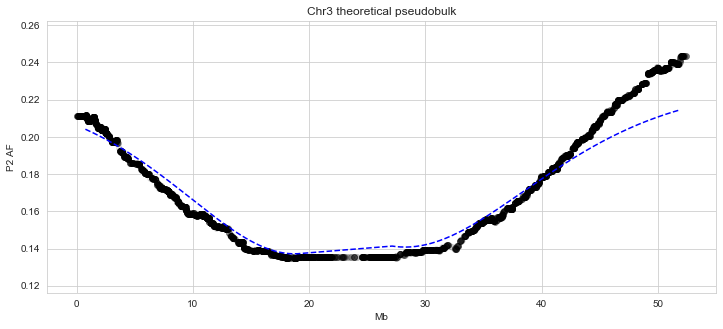

Driver strength: 22.88


In [71]:
WRAP_all(tsv='SIZE_TEST_crossovers.tsv', path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/')

I have determined that the way I am simulating size distortion is severely underestimating the strength that I input. When I have been thinking I've been using 20% size distortion it really has been around 7% because of the way my methods have been simulating it. In reality I've only been able to reduce the size distortion by about 50-75%

# Update size distortion sim methods:

In order to change the way I am simulating this I am going to use the expected proportion of non-unique cells to generate a vector of that length. Each cell has an equal probability of being placed into that vector except for the cells that have the size distortion genotype which will have an increased probability proportional to the strength of segregation distortion. 

In [78]:
#When probs are uniform
cells = [0,1,2,3,4]
probs = [.2,.2,.2,.2,.2] 
print(np.random.choice(a=cells, size=10, p=probs))

[2 4 4 2 4 3 1 4 4 2]


In [104]:
#When probs are weighted
weighted_cells = [3, 4]
weight = .2
cells = np.asarray([0,1,2,3,4])
uniform_p = 1/len(cells)
weighted_p = uniform_p + uniform_p*weight
modifier = (len(weighted_cells) * uniform_p * weight) / abs((len(cells) - len(weighted_cells)))
modified_p = uniform_p - modifier

distr = np.full(shape=(len(cells)), fill_value=modified_p)
distr[weighted_cells] = weighted_p

sampling = np.random.choice(a=cells, size=10000, p=distr)

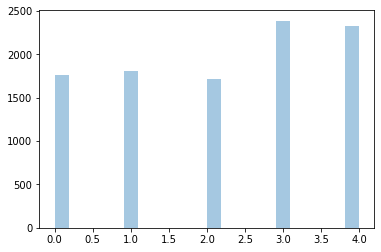

In [108]:
sns.distplot(sampling, kde=False)
plt.show()
plt.close()

Now I have tried a new method of simulating and am going to test to see what SD parameter I get I hope I get 20%...

SNP input loaded... 2201 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


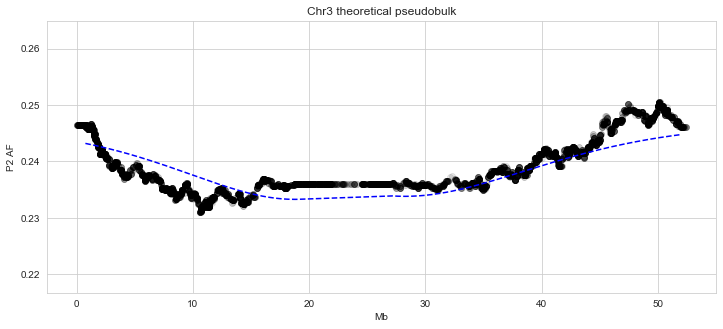

Driver strength: 3.39


In [122]:
WRAP_all(tsv='SIZE_TEST_crossovers.tsv', path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/')

Still not working... 

Input as 50% size distortion...

SNP input loaded... 2398 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


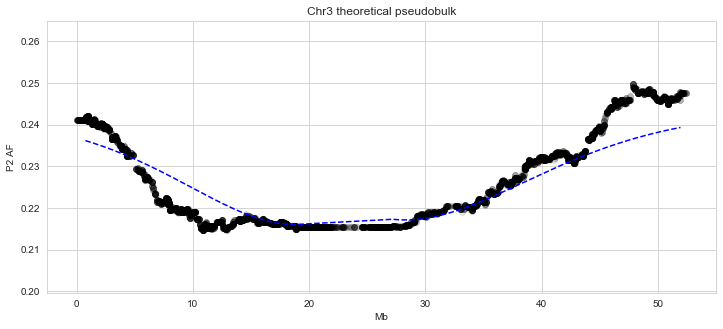

Driver strength: 6.88


In [125]:
WRAP_all(tsv='SIZE_TEST_crossovers.tsv', path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/')

It really does not seem to be working in the way I would like at all unfortunately. Debugging my simulator has shown me that ~18% of the cells should have a P1 homozygote genotype at the centromeric locus by virtue of size distortion, however this doesn't seem to be manifesting itself in the graph produced. As an orthologous method of debugging I am going to use the pseudobulk data to generate a similar graph.

In [130]:
def wrapPseudo():
    myAnalysis = analyzeSEQ()
    myAnalysis.polarized_samples = myAnalysis.load_SNP_array(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/',
                                                            snp_array='SIZE_TEST.npy', encoding='latin1')
    myAnalysis.pseudoBulk([i for i in range(len(myAnalysis.polarized_samples))])
    params,e, AFs = myAnalysis.estimateSD_params(myAnalysis.pseudoBulk_data)
    
        #Do the plotting
    with sns.axes_style('whitegrid'):
        fig = plt.figure(figsize=(12,5))
        sns.scatterplot(myAnalysis.pseudoBulk_data[1][:,0], myAnalysis.pseudoBulk_data[1][:,1],edgecolor=None, alpha=1, color='red')
        plt.plot(AFs[1][:,0], AFs[1][:,1], linestyle='--', color='green')
        plt.title('Chr3 1x coverage pseudobulk')
        plt.xlabel('Mb')
        plt.ylabel('P2 AF')
        plt.show()
        plt.close()

    print('Driver strength: {0:.2f}'.format(params[1][0]*100))
    

SNP input loaded... 2398 cells read in...
Calculating allele frequencies for pseudobulk data in 200kb bins
Fitting parameters for segregation distortion inference and predicting allele frequencies...


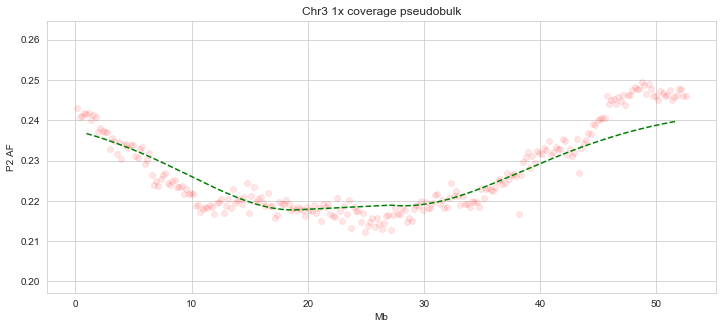

Driver strength: 6.54


In [132]:
wrapPseudo()

Using the pseudobulk data itself gives me the exact same result as before with no change. The size distortion parameter that is displayed doesn't seem like what it should be given the input parameters. When I try to put in a 50% distortion I see that I get like 75% of the non-unique cells are drawn from size distorted indviduals. 

If we try to work out this math:

75% cells are unique. 50% of those will be P1/P1 by mendel segregation so ~37.5% of the uniq cells will be P1/P1. Then if we re-sample those uniq cells and draw 75% of the remaining 25% from the P1/P1 pool we would get... 18.75% P1/P1 duplicates. Which means that we ought to be seeing 37.5 + 18.75 = 56.25% of the individuals be P1/P1, and the remaining 43.75% would be P1/P2. If we pool the allele frequencies then we would see average 21.1875% allele frequency at the centromere.

Now that I have worked out the math this actually seems completely correct, which seems bizzare, but the math doesn't lie. But now that I know this I can work out the minimum P2 allele frequency that could be seen by using this method of generation. 

If you are guaranteed to draw P1/P1 cells from the non-uniq pool then you add 25% + 37.5% = 62.5% P1/P1. Therefore, the P2 allele frequency at the centromere would be 18.75%. 

I think this could probably be parameterized as a function where the proportion of unique:non-uniq cells and the "size distortion" would predict how much effect size distortion could have on our driver strength estimates. 

SNP input loaded... 1950 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


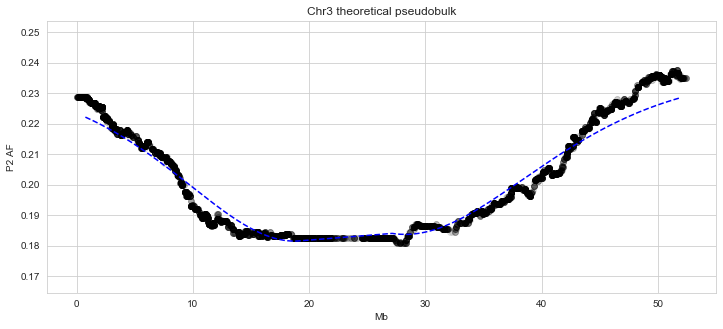

Driver strength: 13.89


In [136]:
WRAP_all(tsv='SIZE_TEST_2k_crossovers.tsv', path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/')

Above I have the same size distortion parameter, but the number of input individuals is only 1,000 instead of 4,000. You can plainly see that the number of non-uniq individuals that would be expected given the sampling without replacement severely effects how we see the size distortion. I think that it may be better for me to do a rather extensive over haul of the simulator again, but this time use the weighted probability distribution to immediately generate the numbers of unique and non-unique individuals. I think this may be the most accurate weigh of simulating a size distortion based on unequal cell contribution. 

SNP input loaded... 1950 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


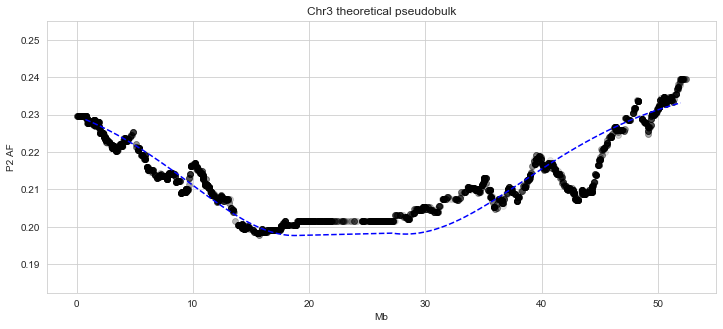

Driver strength: 10.74


In [141]:
WRAP_all(tsv='SIZE_TEST_NEW_crossovers.tsv', path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/')

SNP input loaded... 1997 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


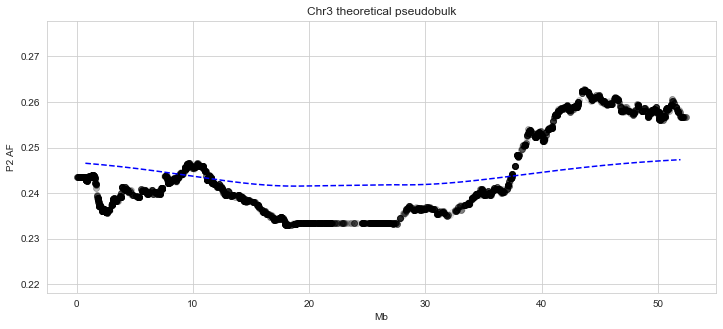

Driver strength: 1.72


In [148]:
WRAP_all(tsv='SIZE_TEST_crossovers.tsv', path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/')

SNP input loaded... 1997 cells read in...
Fitting parameters for segregation distortion inference and predicting allele frequencies...


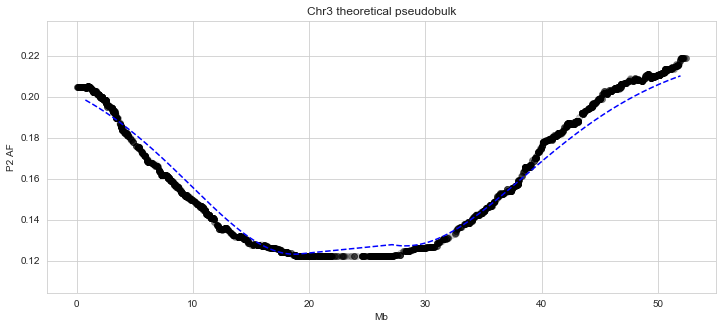

Driver strength: 25.73


In [149]:
WRAP_all(tsv='BIG_SIZE_TEST_crossovers.tsv', path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/')